In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})
# scikit-learn
from sklearn import datasets, linear_model, preprocessing, neighbors
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer

In [2]:
# Taipei
df_a = pd.read_csv('concat/all_A_台北市_A.csv', engine='python')
df_b = pd.read_csv('concat/all_A_台北市_B.csv', engine='python')

In [ ]:
# New Taipei City 
df_a = pd.read_csv('concat/all_F_新北市_A.csv', engine='python')
df_b = pd.read_csv('concat/all_F_新北市_B.csv', engine='python')

In [ ]:
# Taoyuan 
df_a = pd.read_csv('concat/all_H_桃園市_A.csv', engine='python')
df_b = pd.read_csv('concat/all_H_桃園市_B.csv', engine='python')

In [ ]:
# Taichung
df_a = pd.read_csv('concat/all_B_台中市_A.csv', engine='python')
df_b = pd.read_csv('concat/all_B_台中市_B.csv', engine='python')

In [ ]:
# Tainan 
df_a = pd.read_csv('concat/all_D_台南市_A.csv', engine='python')
df_b = pd.read_csv('concat/all_D_台南市_B.csv', engine='python')

In [ ]:
# Kaohsiung 
df_a = pd.read_csv('concat/all_E_高雄市_A.csv', engine='python')
df_b = pd.read_csv('concat/all_E_高雄市_B.csv', engine='python')

In [3]:
df_b['建築完成年月']=df_b['交易年月日']

In [4]:
# concat two dataframe
df = pd.concat([df_a, df_b],ignore_index=True)
df = df.drop(['Unnamed: 0'],axis=1)

In [5]:
# slice datetime
df['交易年'] = (df['交易年月日']/10000).astype('int64')

In [6]:
# select specific columns with fancy index
df_fi = df[["鄉鎮市區",
            "交易標的",
            "建物移轉總面積平方公尺",
            "都市土地使用分區",
            "交易年",
            "交易筆棟數",
            "移轉層次",
            "總樓層數",
            "建物型態",
            
            "主要用途",
            "主要建材",
            "建築完成年月",
            "建物現況格局-房",
            "建物現況格局-廳",
            "建物現況格局-衛",
            "有無管理組織",
            "總價元",
            "單價元平方公尺" ,
            "車位總價元"]]

In [7]:
# remove garage & land & NaN columns
con1 = ~(df_fi["交易標的"] == "車位")
con2 = ~(df_fi["交易標的"] == "土地")
df_no_gar_land = df_fi[con1 & con2]
df_dropna = df_no_gar_land.dropna()

In [8]:
# 篩選"建物型態"
df_type=df_dropna.copy()
df_type=df_type[~df_type['建物型態'].isin(['店面(店鋪)','辦公商業大樓','其他','廠辦'])]

In [10]:
# 篩選"土地使用分區"
df_type.loc[df_type['都市土地使用分區'].str.contains('住'),'都市土地使用分區']='住'
df_type.loc[df_type['都市土地使用分區'].str.contains('商'),'都市土地使用分區']='商'
df_landuse=df_type[~df_type['都市土地使用分區'].str.contains('都市')]
df_landuse=df_landuse[((df_landuse['都市土地使用分區']!='農') & (df_landuse['都市土地使用分區']!='工'))]

住     121227
商      53841
其他      8171
Name: 都市土地使用分區, dtype: int64

In [11]:
# 篩選"主要建材"
# df_landuse['主要建材'].value_counts()>1000
df_ing=df_landuse.groupby("主要建材").filter(lambda ing: len(ing) > 500)
df_ing=df_ing[df_ing['主要建材']!='見其他登記事項']

In [12]:
# delete useless floor
useless_floor = df_ing["移轉層次"].str.len() > 6
df_floorclr = df_ing[~useless_floor]

# modify floor value
df_floormod=df_floorclr.copy()
df_floormod["移轉層次"] = df_floormod["移轉層次"].str[:2]

# select count value > 500
df_floormod = df_floormod.groupby("移轉層次").filter(lambda grp: len(grp) > 500)

# 刪除"移轉層次"與"總樓層數"不合理欄位
df_floor_all=df_floormod[~df_floormod['移轉層次'].isin(['陽台','地下','(空白)','見其他登記事項','見使用執照','社登'])]
# df_floor_all

In [14]:
# 刪除只有"衛"的欄位
df_mask1=df_floor_all["建物現況格局-房"]==0
df_mask2=df_floor_all["建物現況格局-廳"]==0
df_mask3=df_floor_all["建物現況格局-衛"]==1
df_pattern_del_001=df_floor_all[~(df_mask1 & df_mask2 & df_mask3)]

In [15]:
# 將房廳衛000設為111
df_mask4=df_pattern_del_001["建物現況格局-房"]==0
df_mask5=df_pattern_del_001["建物現況格局-廳"]==0
df_mask6=df_pattern_del_001["建物現況格局-衛"]==0
df_pattern_del_001.loc[df_mask4 & df_mask5 & df_mask6, ["建物現況格局-房","建物現況格局-廳","建物現況格局-衛"]]=1
df_pattern_del_111=df_pattern_del_001
df_pattern_del_111=df_pattern_del_111[df_pattern_del_111['建物移轉總面積平方公尺']!=0]

In [16]:
# 計算每坪價格
df_cal=df_pattern_del_111.copy()
df_cal['總價元']=df_cal['總價元']/10000
df_cal['建物移轉總面積坪']=df_cal['建物移轉總面積平方公尺']*0.3025
df_cal['每坪價格']=(df_cal['總價元'])/df_cal['建物移轉總面積坪']

In [17]:
# separate 交易筆棟數
df_sep=df_cal.copy()
a=df_cal["交易筆棟數"].str.split("土地|建物|車位", expand=True)
df_sep["車位"]=a[3].astype('int64')

In [24]:
# 移除符號
column=df_sep['建築完成年月'].astype('str')
mask_dash=column.str.contains(' ') | column.str.contains('-') | column.str.contains('/')
df_del_dash=df_sep[~mask_dash]

In [25]:
# 計算屋齡
df_del_dash['建築完成年'] = df_del_dash['建築完成年月'].astype('float64')//10000
df_del_dash['屋齡']=(df_del_dash['交易年']-df_del_dash['建築完成年']).astype('int64')
mask_year=df_del_dash['屋齡']>-10
df_del_year=df_del_dash[mask_year]

In [26]:
# 新增房間數 (因房廳衛相關性高故房+廳+衛=房間數)
df_main_room=df_del_year.copy()
df_main_room["房間數"]=df_main_room["建物現況格局-房"]+df_main_room["建物現況格局-廳"]+df_main_room["建物現況格局-衛"]
df_main_room=df_main_room.drop(["建物現況格局-房","建物現況格局-廳","建物現況格局-衛"],axis=1)

In [47]:
# 篩選"主要用途"含"住"
df_main_living=df_main_room.loc[df_main_room["主要用途"].str.contains('住')]
# 篩選"主要用途"移除有複雜說明欄位
df_main_usage=df_main_living[df_main_living['主要用途'].isin(['住家用','國民住宅','集合住宅','住商用'])]

In [48]:
# 刪除車位=0 車位總價元=\=0
mask_garzero=(df_main_usage['車位總價元']!=0) & (df_main_usage['車位']==0)
df_main_usage=df_main_usage[~mask_garzero]

<AxesSubplot:xlabel='建物移轉總面積坪', ylabel='每坪價格'>

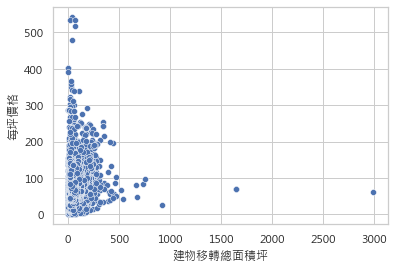

In [49]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

sns.scatterplot(data=df_main_usage, x="建物移轉總面積坪", y="每坪價格")

In [50]:
# 篩選不合理坪數及價格
df_main_usage=df_main_usage[(df_main_usage['建物移轉總面積坪']<=1000) & (df_main_usage['建物移轉總面積坪']>5)]
df_main_usage=df_main_usage[(df_main_usage['每坪價格']<=800) & (df_main_usage['每坪價格']>10)]

In [52]:
# normalization 每坪價格
min_std=df_main_usage['每坪價格'].mean()-3*df_main_usage['每坪價格'].std()
max_std=df_main_usage['每坪價格'].mean()+3*df_main_usage['每坪價格'].std()
print(max_std,min_std)

126.84746485479909 -7.934442250919382


In [53]:
# 移除 outliner
mask_3=df_main_usage['每坪價格']>max_std
df_outlier_std=df_main_usage[~mask_3]

In [54]:
# normalization 建物移轉總面積坪
min_std=df_outlier_std['建物移轉總面積坪'].mean()-3*df_outlier_std['建物移轉總面積坪'].std()
max_std=df_outlier_std['建物移轉總面積坪'].mean()+3*df_outlier_std['建物移轉總面積坪'].std()
print(max_std,min_std)

119.04385069942067 -39.20633728861306


In [55]:
# 移除 outliner
mask_5=df_outlier_std['建物移轉總面積坪']>max_std
df_outlier_all_std=df_outlier_std[~mask_5]
df_outlier_all_std=df_outlier_all_std.reset_index(drop=True)

<AxesSubplot:xlabel='建物移轉總面積坪', ylabel='每坪價格'>

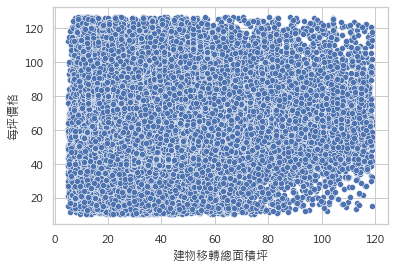

In [56]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

sns.scatterplot(data=df_outlier_all_std, x="建物移轉總面積坪", y="每坪價格")

C:\Python\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<AxesSubplot:>

C:\Python\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


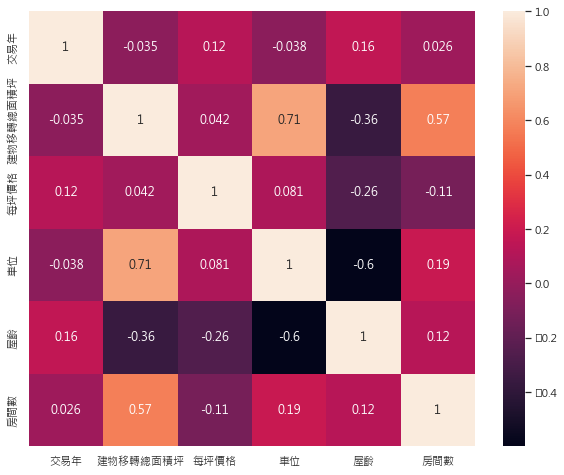

In [57]:
import seaborn as sns
from matplotlib.font_manager import FontProperties
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

plt.figure(figsize=(10,8))
sns.heatmap(df_outlier_all_std.corr(),annot=True)
# new_df_encoding.corr()

In [ ]:
df_all=df_outlier_all_std.copy()
df_all.loc[df_all[df_all['移轉層次']=='全'].index,'移轉層次']=df_all.loc[df_all[df_all['移轉層次']=='全'].index,'總樓層數']
df_all

In [ ]:
df_all.to_csv('taipei_dataset_addB.csv')

In [ ]:
new_all_floor = {"總樓層數": 
             {"一層" : 1, 
              "二層" : 2, 
              "三層" : 3, 
              "四層" : 4, 
              "五層" : 5, 
              "六層" : 6, 
              "七層" : 7, 
              "八層" : 8, 
              "九層" : 9, 
              "十層" : 10, 
              "十一層" : 11, 
              "十二層" : 12, 
              "十三層" : 13, 
              "十四層" : 14, 
              "十五層" : 15, 
              "十六層" : 16, 
              "十七層" : 17, 
              "十八層" : 18, 
              "十九層" : 19, 
              "二十層" : 20,
              "二十一層" : 21, 
              "二十二層" : 22, 
              "二十三層" : 23, 
              "二十四層" : 24, 
              "二十五層" : 25, 
              "二十六層" : 26, 
              "二十七層" : 27, 
              "二十八層" : 28, 
              "二十九層" : 29, 
              "三十層" : 30,
              "三十一層" : 31,
              "三十二層" : 32,
              "三十三層" : 33,
              "三十四層" : 34,
              "三十五層" : 35,
              "三十六層" : 36,
              "三十七層" : 37,
              "三十八層" : 38,
              "三十九層" : 39,
              "四十層" : 40,
              "四十一層" : 41,
              "四十二層" : 42,
              "四十三層" : 43,
              "四十六層" : 46,
              "六十八層" : 68
             }
            }

In [ ]:
df_floor_all = df_main.replace(new_all_floor)
df_floor_all=df_floor_all[df_floor_all["總樓層數"]!='(空白)']
df_floor_all=df_floor_all[df_floor_all["總樓層數"]!='見其他登記事項']
df_floor_all=df_floor_all[df_floor_all["總樓層數"]!='見使用執照']
df_floor_all=df_floor_all[df_floor_all["總樓層數"]!='社登']
df_floor_all["總樓層數"]=df_floor_all["總樓層數"].astype('int64')

In [ ]:
df_floor_all=df_floor_all[~((df_floor_all['建物型態']=='透天厝') & (df_floor_all['總樓層數']>8))]

In [ ]:
new_floor = {"移轉層次": 
             {"一層" : 1, 
              "二層" : 2, 
              "三層" : 3, 
              "四層" : 4, 
              "五層" : 5, 
              "六層" : 6, 
              "七層" : 7, 
              "八層" : 8, 
              "九層" : 9, 
              "十層" : 10, 
              "十一" : 11, 
              "十二" : 12, 
              "十三" : 13, 
              "十四" : 14, 
              "十五" : 15, 
              "十六" : 16, 
              "十七" : 17, 
              "十八" : 18, 
              "十九" : 19, 
              "二十" : 20,
              "三十" : 30
             }
            }

In [ ]:
df_floornum = df_floor_all.replace(new_floor)
df_floornum["移轉層次"]=df_floornum["移轉層次"].astype('int64')
# df_floornum["交易年"]=df_floornum["交易年"].astype('str')
# df_floornum.head(5)

In [ ]:
df_floornum.loc[(df_floornum['主要建材']=='鋼骨鋼筋混凝土造') | (df_floornum['主要建材']=='鋼骨鋼筋混凝土構造'),['主要建材']]=1
df_floornum.loc[df_floornum['主要建材']=='鋼骨混凝土造',['主要建材']]=2
df_floornum.loc[(df_floornum['主要建材']=='鋼骨造')| (df_floornum['主要建材']=='鋼骨構造'),['主要建材']]=3
df_floornum.loc[(df_floornum['主要建材']=='鋼筋混凝土造') | (df_floornum['主要建材']=='鋼筋混凝土構造')| (df_floornum['主要建材']=='鋼造')| (df_floornum['主要建材']=='鋼筋混凝土加強磚造')| (df_floornum['主要建材']=='鋼筋混凝土'),['主要建材']]=4
df_floornum.loc[(df_floornum['主要建材']=='加強磚造') | (df_floornum['主要建材']=='磚造'),['主要建材']]=5
df_floornum.loc[df_floornum['有無管理組織']=='有',['有無管理組織']]=1
df_floornum.loc[df_floornum['有無管理組織']=='無',['有無管理組織']]=0
df_floornum=df_floornum[df_floornum['主要建材']!='見使用執照']
df_floornum=df_floornum[df_floornum['主要建材']!='見其它登記事項']

In [ ]:
df_floornum['主要建材']=df_floornum['主要建材'].astype('int64')
df_floornum['有無管理組織']=df_floornum['有無管理組織'].astype('int64')

In [ ]:
df_usage=df_floornum[df_floornum['主要用途']=='住家用']

In [ ]:
df_usage['樓層比']=df_usage['移轉層次']/df_usage['總樓層數']

In [ ]:
df_usage=df_usage.drop(['主要用途','建物','土地','移轉層次'],axis=1)

In [ ]:
df_usage=df_usage[df_usage['車位']<10]
df_usage=df_usage[df_usage['房間數']<10]

In [ ]:
df_usage=df_usage[df_usage['交易年']>=102]
df_usage['交易年'].value_counts()
new_year = {"交易年": 
             {102 : 1, 
              103 : 2, 
              104 : 3, 
              105 : 4, 
              106 : 5, 
              107 : 6, 
              108 : 7, 
              109 : 8, 
              110 : 9, 
              111 : 10
             }
            }
df_new_year = df_usage.replace(new_year)

In [ ]:
# onehot encoding
df_oh=pd.get_dummies(df_new_year)
df_oh

In [ ]:
df_oh.to_csv('taipei_predictset_onehot.csv')